### Лабораторная работа 3. Ансамбли, отбор признаков

Результат лабораторной работы − отчет. Мы предпочитаем принимать отчеты в формате ноутбуков Jupyter (ipynb-файл). Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Помимо ответов на вопросы, в отчете так же должен быть код, однако чем меньше кода, тем лучше всем: нам − меньше проверять, вам —  проще найти ошибку или дополнить эксперимент. При проверке оценивается четкость ответов на вопросы, аккуратность отчета и кода.


### Оценивание и штрафы

* Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи)
* Максимально допустимая оценка за работу — 15 баллов
* Сдавать задание после указанного срока сдачи нельзя
* «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов и понижают карму (подробнее о плагиате см. на странице курса)
* Если вы нашли решение какого-то из заданий в открытом источнике, необходимо прислать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник)
* Не оцениваются задания с удалёнными формулировками
* Не оценивается лабораторная работа целиком, если она была выложена в открытый источник

## Введение

Обратившись к Питеру Флаху, перечислим еще раз три ингридиента машинного обучения: задачи, модели и признаки.

Наш курс вводный, и темы извлечения признаков затрагивает очень неглубоко (на ум приходят модели мешка слов или использование дерева решений, как генератора категориального признака "номер листа"). 

На вводной лекции Саша Крайнов рассказывал вам о том, что в задачах машинного зрения применяется подход, когда одна нейронная сеть обучает и "извлекатель признаков" (на жаргоне -- тушка) и классификатор поверх данного слоя признаков (на жаргоне -- голову). 
В данной лабораторной работе (и сопряженным с ней конкурсе) мы возьмём предобученную нейронную сеть, входящую в набор моделей torchvision.models, и оставим от нее только "тушку". Таким образом у нас будет генератор признаков.

Мы сгенерировали для вас dataset с извлечёнными из картинок признаками.

Как вы понимаете, нет никаких гарантий, что данный набор признаков будет полезен для нашей задачи.

А значит, вы сможете:
  * применить методы отбора признаков 
  * обучить на лучших подмножествах модели, которые вы еще не испытвали в лабораторных
    * модели на основе растояний
    * деревья решений
    * ансамбли над деревьями решений.
  * отобрать лучшие модели
  
И получить таким образом хорошее baseline решение для конкурса.

In [514]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_classif, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from random import randint
import optuna
import shap
import tqdm
from catboost import CatBoostClassifier

plt.rcParams['figure.figsize'] = (14, 7)

## Задача и Dataset

Данные о задаче доступны в соревновании https://www.kaggle.com/t/c5b18ffd89ec43aa95477548b54f0e7e

Метрика -- AUC ROC

In [3]:
df_full = pd.read_csv('train.csv')
X_full, y = df_full.drop(columns=['label']), df_full['label']
X_full.head()

,A_000,A_001,A_002,A_003,A_004,A_005,A_006,A_007,A_008,A_009,...,A_502,A_503,A_504,A_505,A_506,A_507,A_508,A_509,A_510,A_511
0,0.860262,0.973692,0.928669,0.983180,0.921490,0.893082,0.896374,1.166348,0.976090,0.934188,...,0.884115,0.825269,0.867979,0.813514,1.094121,1.041853,0.994663,0.941488,1.060160,0.937741
1,0.974091,0.980219,0.867670,1.028374,0.982019,0.932177,0.963477,1.156632,0.862525,0.905283,...,0.934491,0.910559,0.906479,0.850581,1.110033,0.924904,0.928172,0.940252,1.120156,0.954470
2,0.908975,0.910847,0.896063,1.077621,0.898831,0.947538,1.012399,1.129408,0.898499,0.961152,...,0.955161,0.965252,0.893417,0.876576,1.109091,0.940675,0.976045,0.963731,0.982111,0.905192
3,0.908817,0.974266,0.926658,1.039647,0.966214,0.856318,0.920029,1.056084,0.895255,0.975229,...,0.947294,0.863783,0.908302,0.889247,1.150731,0.832890,0.945889,0.994688,1.094576,0.991118
4,0.868417,0.919241,0.868347,0.917431,0.943406,0.874338,0.966561,1.200914,0.991275,0.943415,...,1.016494,0.880458,0.904808,0.902078,1.062960,0.960974,0.947542,0.911971,1.077786,0.916956


(array([ 56., 229., 142.,  49.,  20.,   6.,   4.,   2.,   3.,   1.]),
 array([0.81804223, 0.8743171 , 0.93059197, 0.98686684, 1.04314171,
        1.09941658, 1.15569146, 1.21196633, 1.2682412 , 1.32451607,
        1.38079094]),
 <BarContainer object of 10 artists>)

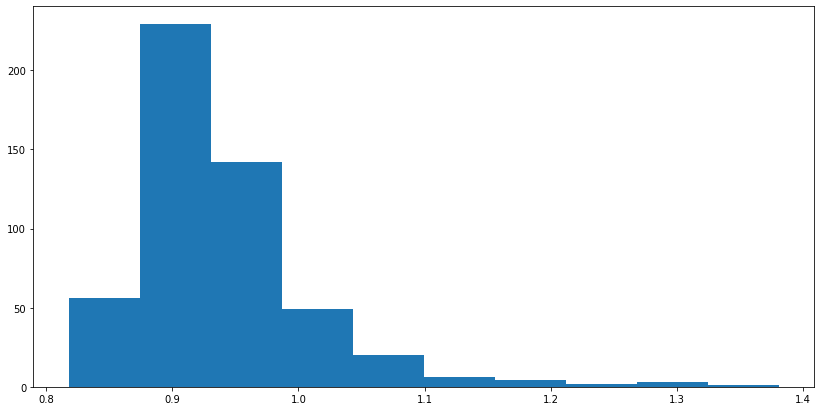

In [4]:
plt.hist(X_full.mean(axis=0))

Есть желание заранее отмасштабировать данные, чтобы алгоритмы, для которых это существенно, были с другими в равных условиях.

In [5]:
scaler = MinMaxScaler()

def Scale(df, train=True):
    if train:
        scaler.fit(df)
    np_scaled = scaler.transform(df)
    df_new = pd.DataFrame(np_scaled, columns=df.columns)
    return df_new

X_full = Scale(X_full)
X_full.head(10)

,A_000,A_001,A_002,A_003,A_004,A_005,A_006,A_007,A_008,A_009,...,A_502,A_503,A_504,A_505,A_506,A_507,A_508,A_509,A_510,A_511
0,0.360837,0.632869,0.595462,0.362489,0.577529,0.650654,0.397140,0.643683,0.660644,0.524372,...,0.373843,0.334489,0.381283,0.435012,0.577473,0.686453,0.717945,0.634543,0.594547,0.452758
1,0.741514,0.652486,0.363845,0.500242,0.782237,0.784131,0.623618,0.617225,0.320164,0.434504,...,0.544160,0.645951,0.531172,0.556442,0.622979,0.360023,0.509758,0.630568,0.756259,0.511313
2,0.523748,0.443987,0.471653,0.650352,0.500898,0.836577,0.788731,0.543093,0.428018,0.608205,...,0.614046,0.845684,0.480320,0.641601,0.620283,0.404043,0.659652,0.706107,0.384174,0.338826
3,0.523218,0.634596,0.587826,0.534604,0.728784,0.525132,0.476977,0.343424,0.418294,0.651973,...,0.587449,0.475133,0.538268,0.683112,0.739368,0.103193,0.565232,0.805705,0.687311,0.639592
4,0.388109,0.469214,0.366415,0.162079,0.651648,0.586658,0.634027,0.737812,0.706171,0.553061,...,0.821411,0.536029,0.524664,0.725146,0.488358,0.460702,0.570407,0.539578,0.642054,0.380005
5,0.370319,0.619581,0.709963,0.519040,0.570139,0.657272,0.315212,0.513777,0.701542,0.758356,...,0.363082,0.568483,0.841092,0.355990,0.302384,0.579314,0.641528,0.542906,0.503958,0.528631
6,0.627770,0.591782,0.758493,0.525986,0.646399,0.375588,0.525387,0.304223,0.378038,0.607173,...,0.648715,0.598479,0.590839,0.489825,0.705311,0.628904,0.662226,0.481360,0.813659,0.553920
7,0.281005,0.518105,0.610326,0.355314,0.472125,0.476898,0.686359,0.703415,0.410166,0.621838,...,0.458665,0.571849,0.646470,0.438666,0.538978,0.615417,0.637284,0.665234,0.556165,0.324445
8,0.648819,0.629282,0.873192,0.220910,0.697100,0.801211,0.398387,0.717010,0.696349,0.552062,...,0.492569,0.770017,0.556446,0.635692,0.379803,0.557488,0.663792,0.602254,0.379236,0.425508
9,0.783180,0.589710,0.649417,0.483105,0.510441,0.589543,0.781572,0.662892,0.457775,0.548873,...,0.607683,0.941185,0.458550,0.636544,0.646512,0.543301,0.755932,0.722401,0.592236,0.306883


**Задание 1** (2.0 балл)
Оцените признаки до моделирования тяжелыми моделями.
  * Оцените связь между целевой меткой и значением признака при помощи статистических тестов, воспользщовавшись разделом [Univariate feature selection из sklearn](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection)

Оценим значение взимной информации каждого признака с целевой меткой и взглянем на общую картину.

In [6]:
gus = GenericUnivariateSelect(score_func=mutual_info_classif, mode='k_best')
gus.fit(X_full, y)

GenericUnivariateSelect(mode='k_best',
                        score_func=<function mutual_info_classif at 0x7f4d6d22f510>)

Text(0, 0.5, 'Mutual information')

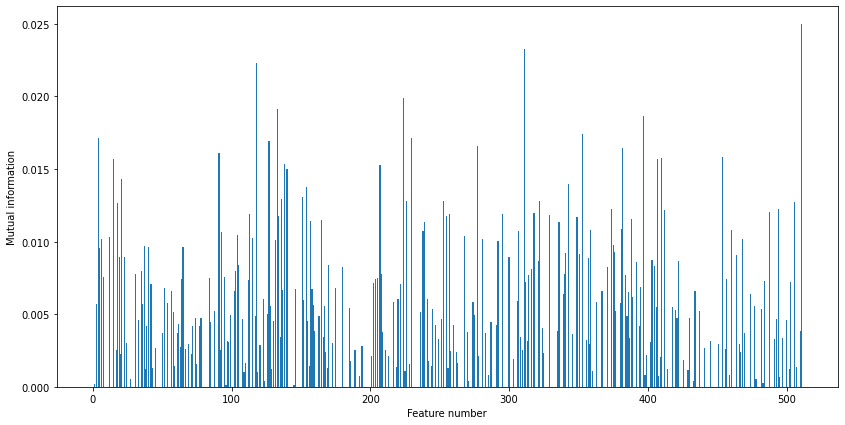

In [7]:
plt.bar(np.arange(512), gus.scores_)
plt.xlabel('Feature number')
plt.ylabel('Mutual information')

Видим, что есть неколько признаков, выделяющихся по этому показателю. Построим отдельный график для топ-20, предварительно упорядочив их.

Text(0, 0.5, 'Mutual information')

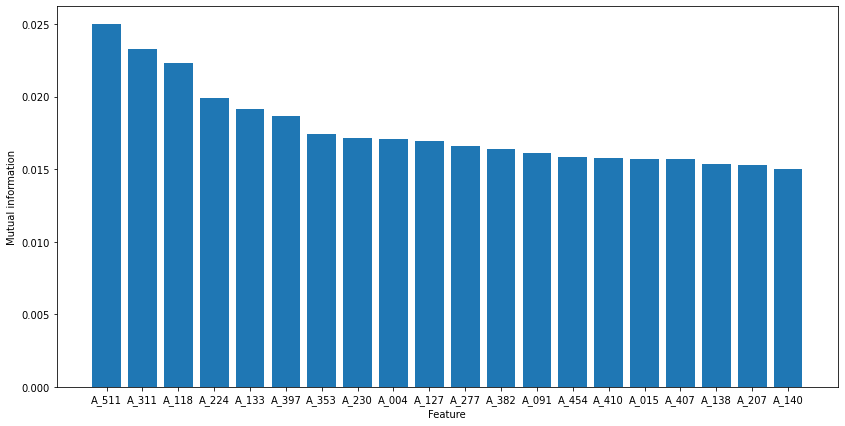

In [8]:
gus.set_params(param=20)
best_scores_map = list(zip(gus.scores_[gus.get_support()], X_full.columns[gus.get_support()]))
best_scores_map.sort(reverse=True)
plt.bar(np.array(best_scores_map)[:, 1], np.array(best_scores_map)[:, 0].astype(float))
plt.xlabel('Feature')
plt.ylabel('Mutual information')

Теперь проделаем то же самое с другой оценивающей функцией

Text(0, 0.5, 'F-value')

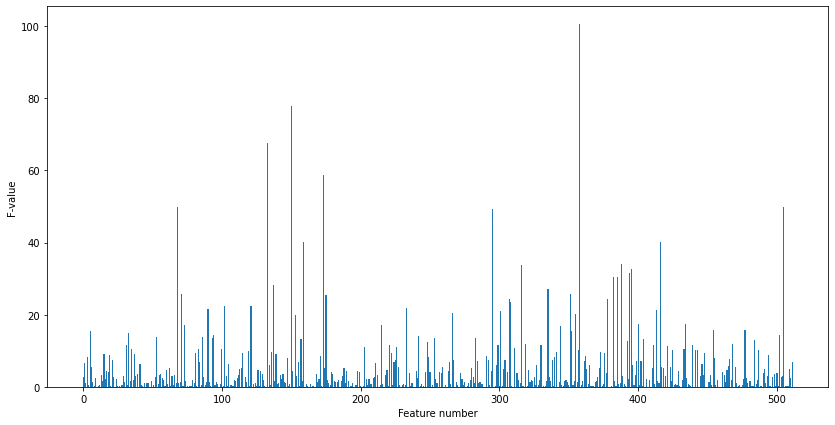

In [9]:
gus2 = GenericUnivariateSelect(mode='k_best', param=20)
gus2.fit(X_full, y)
plt.bar(np.arange(512), gus2.scores_)
plt.xlabel('Feature number')
plt.ylabel('F-value')

Text(0, 0.5, 'F-value')

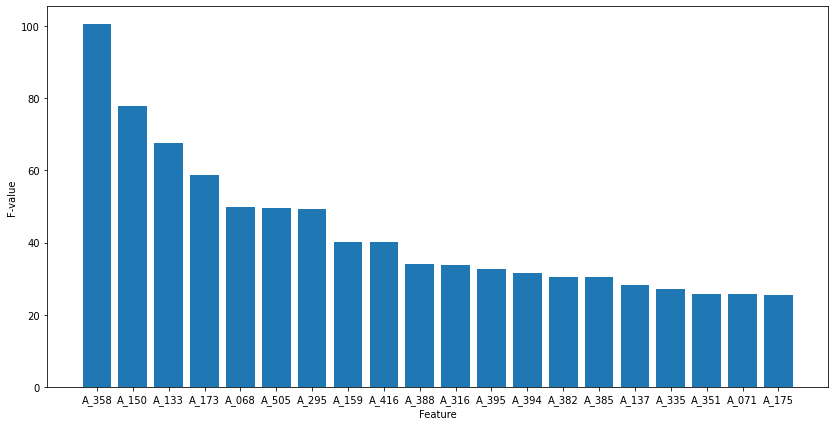

In [10]:
best_scores_map = list(zip(gus2.scores_[gus2.get_support()], X_full.columns[gus2.get_support()]))
best_scores_map.sort(reverse=True)
plt.bar(np.array(best_scores_map)[:, 1], np.array(best_scores_map)[:, 0].astype(float))
plt.xlabel('Feature')
plt.ylabel('F-value')

  * Отранжируйте признаки при помощи линейного классификатора с l1-регуляризацией (например, воспользовавшись [l1-based-feature-selection из sklearn](https://scikit-learn.org/stable/modules/feature_selection.html#l1-based-feature-selection))

In [11]:
def GetNBestLogRegFeatures(estimator, X, y, count, prefit=False):
    if prefit is False:
        estimator.fit(X, y)
    feature_weights = list(zip(list(np.abs(estimator.coef_).reshape(-1)), X.columns[:]))
    feature_weights.sort(reverse=True)
    feature_weights = np.array(feature_weights[:count])
    return np.array(feature_weights[:count])


In [198]:
log_reg_l1 = LogisticRegression(max_iter=500, penalty='l1', solver='liblinear')
best_features = GetNBestLogRegFeatures(log_reg_l1, X_full, y, 20)

Text(0, 0.5, 'Absolute weight in LogReg')

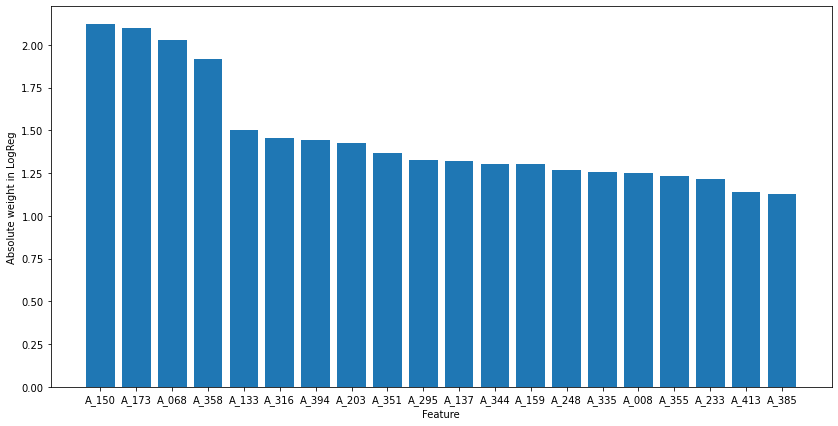

In [195]:
plt.bar(best_features[:, 1], best_features[:, 0].astype(float))
plt.xlabel('Feature')
plt.ylabel('Absolute weight in LogReg')

Заметим, что F-value и логистическая регрессия схожим образом отранжировали признаки

Пользуясь случаем, организуем себе бейзлайн, обучив логистическую регрессию на 210 лучших признаках, согласно выше приведенному тесту.

In [204]:
cross_val_score(log_reg, X_full[GetNBestLogRegFeatures(log_reg_l1, X_full, y, 210)[:, 1]], y,
                scoring='roc_auc', cv=StratifiedKFold(shuffle=True, random_state=228)).mean()

0.8120228391790205

Также хотелось бы проверить качество логистической регресси с L2-регуляризацией. Отберем для нее признаки по той же схеме.

In [205]:
log_reg_l2 = LogisticRegression(max_iter=500, penalty='l2', solver='liblinear')
best_features = GetNBestLogRegFeatures(log_reg_l2, X_full, y, 20)

In [207]:
cross_val_score(log_reg_l2, X_full[GetNBestLogRegFeatures(log_reg_l2, X_full, y, 210)[:, 1]], y,
                scoring='roc_auc', cv=StratifiedKFold(shuffle=True, random_state=228)).mean()

0.8176359822150655

**Задание 2** (0.5 балл)
    Попробуйте снизить размерность базовго набора признаков при помощи PCA.
    Визуализируйте первые 2 главные компоненты, раскрасив примеры меткой класса

Feature 1 mean : -0.01972141543258514 0.019768868308987053
Feature 2 mean : 0.019305629660039174 -0.019352082089442568


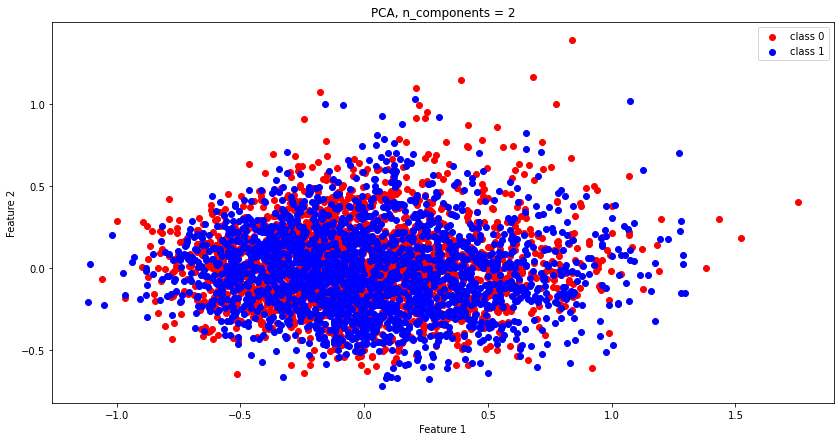

In [15]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_full, y)
reduced_df = pd.DataFrame(np.concatenate([X_reduced, np.array(y).reshape(-1, 1)], axis=1),
                          columns=['feature_1', 'feature_2', 'target'])
class_0 = reduced_df[reduced_df['target'] == 0]
class_1 = reduced_df[reduced_df['target'] == 1]
plt.scatter(class_0['feature_1'], class_0['feature_2'], color='red', label='class 0')
plt.scatter(class_1['feature_1'], class_1['feature_2'], color='blue', label='class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title('PCA, n_components = 2')
print('Feature 1 mean :', class_0['feature_1'].mean(), class_1['feature_1'].mean())
print('Feature 2 mean :', class_0['feature_2'].mean(), class_1['feature_2'].mean())

Из [учебника](https://ysda_trove.gitlab.io/ml-handbook/chapters/hyperparameters_tuning/intro) вы узнали о библиотеках подбора параметров hyperopt и optuna.
Попробуйте применить любую из них в следующем блоке заданий.

Возможно, вы захотите воспользоваться реализацией [Sequential Feature Selection из sklearn](https://scikit-learn.org/stable/modules/feature_selection.html#sequential-feature-selection) для реализации отбора признаков, методом добавления.

**Задание 3** (2 балл)

    Проведите отбор признаков, методом добавления, обучая KNN-классификатор.
    
    Подберите лучшие параметры на отобранных признаках.
    
    Проведите перестановочную оценку влияния отобранных признаков


**Задание 4** (2 балл)
    
    Проведите отбор признаков, методом добавления, обучая решающее дерево классификации.
    
    Подберите лучшие параметры на отобранных признаках.
    
    Проведите перестановочную оценку влияния отобранных признаков


**Задание 5** (2 балл)

    Проведите отбор признаков, методом добавления, обучая классифкатор RandomForest .
    
    Подберите лучшие параметры на отобранных признаках.
    
    Проведите перестановочную оценку влияния отобранных признаков
    

Поскольку задания 3-5 очень схожи между собой, я решил объеденить их в одно, чтобы более наглядно и последовательно сравнить результаты экспериментов и обосновать выбранный подход. Для начала попробуем измерить качество алгоритмов на 10 лучших признаках, отобранных с помощью классического Sequential Feature Selector'a. Попутно обратим внимание на время, требуемое селектором для отбора этих признаков.

In [16]:
knn = KNeighborsClassifier()
knn_sfs = SequentialFeatureSelector(knn, n_features_to_select=10, n_jobs=2, scoring='roc_auc')
knn_sfs.fit(X_full, y)

SequentialFeatureSelector(estimator=KNeighborsClassifier(),
                          n_features_to_select=10, n_jobs=2, scoring='roc_auc')

In [17]:
X_knn_10f = pd.DataFrame(knn_sfs.transform(X_full), columns=X_full.columns[knn_sfs.get_support()])
X_knn_10f.head()

,A_068,A_133,A_150,A_188,A_189,A_347,A_352,A_353,A_358,A_372
0,0.654991,0.496058,0.744134,0.558676,0.693198,0.391260,0.679444,0.675773,0.591261,0.406965
1,0.595276,0.582850,0.574902,0.692201,0.566275,0.560610,0.708899,0.701561,0.519088,0.546789
2,0.596451,0.783633,0.438781,0.596836,0.591931,0.534775,0.812474,0.543035,0.588222,0.676262
3,0.648654,0.337422,0.704922,0.605693,0.646493,0.627380,0.609279,0.772726,0.546976,0.709392
4,0.592623,0.641685,0.631068,0.587084,0.599915,0.303047,0.569281,0.676949,0.453254,0.407625


(Ядро моего ноутбука имеет свойство периодически умирать, поэтому я сохраняю отобранные признаки в явном виде, чтобы, в случае смерти ядра, не проделывать долгие вычисления заново, проходите мимо)

In [16]:
# saving part
knn = KNeighborsClassifier()
knn_10f = ['A_068', 'A_133', 'A_150', 'A_188', 'A_189', 'A_347', 'A_352', 'A_353', 'A_358', 'A_372']
# backup part
X_knn_10f = X_full[knn_10f]
X_knn_10f.head()

,A_068,A_133,A_150,A_188,A_189,A_347,A_352,A_353,A_358,A_372
0,0.654991,0.496058,0.744134,0.558676,0.693198,0.391260,0.679444,0.675773,0.591261,0.406965
1,0.595276,0.582850,0.574902,0.692201,0.566275,0.560610,0.708899,0.701561,0.519088,0.546789
2,0.596451,0.783633,0.438781,0.596836,0.591931,0.534775,0.812474,0.543035,0.588222,0.676262
3,0.648654,0.337422,0.704922,0.605693,0.646493,0.627380,0.609279,0.772726,0.546976,0.709392
4,0.592623,0.641685,0.631068,0.587084,0.599915,0.303047,0.569281,0.676949,0.453254,0.407625


In [18]:
dt = DecisionTreeClassifier()
dt_sfs = SequentialFeatureSelector(dt, n_features_to_select=10, n_jobs=3, scoring='roc_auc')
dt_sfs.fit(X_full, y)

SequentialFeatureSelector(estimator=DecisionTreeClassifier(),
                          n_features_to_select=10, n_jobs=3, scoring='roc_auc')

In [20]:
X_dt_10f = pd.DataFrame(dt_sfs.transform(X_full), columns=X_full.columns[dt_sfs.get_support()])
X_dt_10f.head()

,A_061,A_129,A_169,A_207,A_212,A_241,A_321,A_469,A_474,A_485
0,0.493168,0.624862,0.532255,0.452133,0.418770,0.561258,0.223518,0.371394,0.362124,0.624979
1,0.603907,0.528441,0.589193,0.664135,0.553063,0.652949,0.603849,0.618182,0.632021,0.767449
2,0.464482,0.546182,0.567809,0.560021,0.579259,0.740736,0.413821,0.680826,0.502355,0.780151
3,0.225694,0.636258,0.532716,0.714514,0.710472,0.552052,0.323780,0.539147,0.382428,0.289778
4,0.679869,0.563252,0.539908,0.513499,0.714620,0.476473,0.567722,0.689368,0.588541,0.615151


In [17]:
# saving part
dt = DecisionTreeClassifier()
dt_10f = ['A_061', 'A_129', 'A_169', 'A_207', 'A_212', 'A_241', 'A_321', 'A_469', 'A_474', 'A_485']
# backup part
X_dt_10f = X_full[dt_10f]
X_dt_10f.head()

,A_061,A_129,A_169,A_207,A_212,A_241,A_321,A_469,A_474,A_485
0,0.493168,0.624862,0.532255,0.452133,0.418770,0.561258,0.223518,0.371394,0.362124,0.624979
1,0.603907,0.528441,0.589193,0.664135,0.553063,0.652949,0.603849,0.618182,0.632021,0.767449
2,0.464482,0.546182,0.567809,0.560021,0.579259,0.740736,0.413821,0.680826,0.502355,0.780151
3,0.225694,0.636258,0.532716,0.714514,0.710472,0.552052,0.323780,0.539147,0.382428,0.289778
4,0.679869,0.563252,0.539908,0.513499,0.714620,0.476473,0.567722,0.689368,0.588541,0.615151


In [25]:
rf = RandomForestClassifier(n_estimators=30, random_state=228)
rf_sfs = SequentialFeatureSelector(rf, n_features_to_select=10, n_jobs=-1, scoring='roc_auc')
rf_sfs.fit(X_full, y)

SequentialFeatureSelector(estimator=RandomForestClassifier(n_estimators=30,
                                                           random_state=228),
                          n_features_to_select=10, n_jobs=-1,
                          scoring='roc_auc')

In [26]:
X_rf_10f = pd.DataFrame(rf_sfs.transform(X_full), columns=X_full.columns[rf_sfs.get_support()])
X_rf_10f.head()

,A_057,A_090,A_121,A_133,A_150,A_311,A_321,A_352,A_353,A_358
0,0.288755,0.506977,0.365878,0.496058,0.744134,0.552512,0.223518,0.679444,0.675773,0.591261
1,0.527373,0.503229,0.388468,0.582850,0.574902,0.169687,0.603849,0.708899,0.701561,0.519088
2,0.467381,0.573017,0.862363,0.783633,0.438781,0.586206,0.413821,0.812474,0.543035,0.588222
3,0.357576,0.590183,0.639833,0.337422,0.704922,0.324897,0.323780,0.609279,0.772726,0.546976
4,0.486521,0.427055,0.653476,0.641685,0.631068,0.505919,0.567722,0.569281,0.676949,0.453254


In [18]:
# saving part
rf = DecisionTreeClassifier()
rf_10f = ['A_057', 'A_090', 'A_121', 'A_133', 'A_150', 'A_311', 'A_321', 'A_352', 'A_353', 'A_358']
# backup part
X_rf_10f = X_full[rf_10f]
X_rf_10f.head()

,A_057,A_090,A_121,A_133,A_150,A_311,A_321,A_352,A_353,A_358
0,0.288755,0.506977,0.365878,0.496058,0.744134,0.552512,0.223518,0.679444,0.675773,0.591261
1,0.527373,0.503229,0.388468,0.582850,0.574902,0.169687,0.603849,0.708899,0.701561,0.519088
2,0.467381,0.573017,0.862363,0.783633,0.438781,0.586206,0.413821,0.812474,0.543035,0.588222
3,0.357576,0.590183,0.639833,0.337422,0.704922,0.324897,0.323780,0.609279,0.772726,0.546976
4,0.486521,0.427055,0.653476,0.641685,0.631068,0.505919,0.567722,0.569281,0.676949,0.453254


In [22]:
knn_10f_scores = cross_val_score(knn, X_knn_10f, y, scoring='roc_auc', cv=StratifiedKFold(shuffle=True))
print('KNN CV Scores')
print(f'Mean = {knn_10f_scores.mean()}')
print(f'Std = {knn_10f_scores.std()}')

KNN CV Scores
Mean = 0.6116615425867938
Std = 0.020912369924293097


In [23]:
dt_10f_scores = cross_val_score(dt, X_dt_10f, y, scoring='roc_auc', cv=StratifiedKFold(shuffle=True))
print('Decision Tree CV Scores')
print(f'Mean = {dt_10f_scores.mean()}')
print(f'Std = {dt_10f_scores.std()}')

Decision Tree CV Scores
Mean = 0.5046814277030646
Std = 0.009364199449234849


In [26]:
rf = RandomForestClassifier(random_state=228)
rf_10f_scores = cross_val_score(rf, X_rf_10f, y, scoring='roc_auc', cv=StratifiedKFold(shuffle=True))
print('Random Forest CV Scores')
print(f'Mean = {rf_10f_scores.mean()}')
print(f'Std = {rf_10f_scores.std()}')

Random Forest CV Scores
Mean = 0.6305824428900151
Std = 0.019334540011698546


На лицо плохое качество всех алгоритмов при низкой скорости отбора признаков (к примеру, случайный лес отбирал себе 10 признаков почти час). Это мотивирует нас на некторые эвристики, позволяющие, пусть, немного пожертвовав точностью на каждом отдельном шаге, отобрать большее количество принаков за приемлемое время. Постараемся, учитывая особенности каждого алгоритма, написать собственный настраиваемый селектор, позволяющий приблизить истинное оптимальное подмножество признаков не каким-то случайным априорным образом (как взяв 10 лучших признаков в примере выше), а с помощью какого-либо разумного стоп-критерия.

Построим селектор, жадно добавляющий признаки в оптимальное множество, пока очередное добавление не даст ухудшение качества. Однако основная его идея будет состоять в следующем:

* на каждой итерации мы добавляем не один признак, дающий нам наилучший прирост качества, а n_features_to_add(t) таких признаков, где t - номер итерации, а n_features_to_add - соответственно, функция, от t зависящая
* кроме того, на каждой итерации мы также отбрасываем n_features_to_drop(t) признаков, которые, начиная с итерации t, перестают участвовать в дальнейшем отборе

Такой подход позволит нам найти оптимальный баланс между точностью и скоростью подбора признаков для каждого алгоритма с помощью очень гибкой системы настройки гиперпараметров. С деталями реализации можно ознакомиться в следующей ячейке.

In [27]:
class AdaptiveFeatureSelector:
    def __init__(self, estimator, n_features_to_add=10, n_features_to_drop=0, min_features_selected=0,
                 scoring='roc_auc', cv=None, verbose=False, n_jobs=1):
        self.estimator = estimator
        
        if type(n_features_to_add) is int:
            self.n_features_to_add = lambda iteration: n_features_to_add
        else:
            self.n_features_to_add = n_features_to_add
        
        if type(n_features_to_drop) is int:
            self.n_features_to_drop = lambda iteration: n_features_to_drop
        else:
            self.n_features_to_drop = n_features_to_drop

        self.min_features_selected = min_features_selected
        self.cv = cv    
        self.scoring = scoring
        self.n_jobs = n_jobs
        self.verbose = verbose
        
    
    def fit(self, X, y):
        self.selected_features = []
        features = list(X.columns)
        t = 0
        prev_score = None
        cv_seed = randint(1, 1000)
        
        while True:
            if self.verbose:
                print(f'Iterations passed {t}')
                print(f'    features selected: {len(self.selected_features)}')
                print(f'    features left in pool: {len(features)}')
                print(f'    current score: {prev_score}')

            to_add = min(self.n_features_to_add(t), len(features))
            to_drop = self.n_features_to_drop(t)
            if to_add == 0 or to_drop >= len(features):
                break
            
            feature_scores = dict()
            for feature in features:
                feature_scores[feature] = \
                    cross_val_score(self.estimator, X[self.selected_features + [feature]], y,
                                    cv=self.cv,
                                    scoring=self.scoring, n_jobs=self.n_jobs).mean()
            
            features_sorted = list((dict(sorted(feature_scores.items(), key=lambda item: -item[1]))).keys())
            
            cur_score = cross_val_score(self.estimator, X[self.selected_features + features_sorted[:to_add]],
                                        y, cv=StratifiedKFold(shuffle=True, random_state=cv_seed),
                                        scoring=self.scoring, n_jobs=self.n_jobs).mean()
            
            if (prev_score is not None and cur_score <= prev_score and \
                len(self.selected_features) >= self.min_features_selected) or to_add == len(features):
                for feature in features_sorted[:to_add]:
                    cur_score = cross_val_score(self.estimator, X[self.selected_features + [feature]],
                                                y, cv=StratifiedKFold(shuffle=True, random_state=cv_seed),
                                                scoring=self.scoring, n_jobs = self.n_jobs).mean()
                    if prev_score is not None and cur_score <= prev_score and \
                        len(self.selected_features) >= self.min_features_selected:
                        break
                    prev_score = cur_score
                    self.selected_features.append(feature)
                break
            
            cv_seed = randint(1, 1000)
            prev_score = cross_val_score(self.estimator, X[self.selected_features + [feature]],
                                                y, cv=StratifiedKFold(shuffle=True, random_state=cv_seed),
                                                scoring=self.scoring, n_jobs = self.n_jobs).mean()
            features = features_sorted[to_add:len(features_sorted)-to_drop]
            self.selected_features += features_sorted[:to_add]
            t += 1
    
    def transform(self, X):
        return X[self.selected_features]
    
    
    def get_features(self):
        return self.selected_features


Хочется обратить внимание на одну деталь в реализации: мы не выделяем из выборки отложенную часть, на которой, по идее, могли бы проводить контроль качества, чтобы не переобучиться под KFold. Однако ~избежать переобучения в данном подходе предлагается с помощью рандомизации разбиения выборки на фолды при кросс-валидации на этапе добавления новых признаков в оптимальный набор (собственно, когда нам и нужна объективная оценка качества).

Предпочтение данному подходу было отдано в силу очень уж малого размера нашего исходного датасета: во-первых, выделение отложенной части уменьшило бы его еще сильнее, подорвав устойчивость наших моделей; а, во-вторых, при малом размере датасета, сама отложенная выборка имеет большУю вероятность оказаться непоказательной, из-за чего нам бы не очень хотелось постоянно оценивать свою модель только на ней.

Протестируем наш селектор, отобрав с помощью него лучшие 10 фичей по стратегии Sequenced Feature Selector'а, и сравним результаты с полученными ранее.

In [264]:
knn = KNeighborsClassifier()
knn_afs = AdaptiveFeatureSelector(knn, n_features_to_add=lambda t: (t < 10) * 1, n_features_to_drop=0,
                              verbose=True, n_jobs=3)
knn_afs.fit(X_full, y)

Iterations passed 0
    features selected: 0
    features left in pool: 512
    current score: None
Iterations passed 1
    features selected: 1
    features left in pool: 511
    current score: 0.5303655050847038
Iterations passed 2
    features selected: 2
    features left in pool: 510
    current score: 0.5079298178483751
Iterations passed 3
    features selected: 3
    features left in pool: 509
    current score: 0.5269196144151816
Iterations passed 4
    features selected: 4
    features left in pool: 508
    current score: 0.5063498122222084
Iterations passed 5
    features selected: 5
    features left in pool: 507
    current score: 0.5394003716432286
Iterations passed 6
    features selected: 6
    features left in pool: 506
    current score: 0.5537671683037918
Iterations passed 7
    features selected: 7
    features left in pool: 505
    current score: 0.579555759317788
Iterations passed 8
    features selected: 8
    features left in pool: 504
    current score: 0.577188

In [269]:
knn_afs.transform(X_full).head()

,A_353,A_352,A_372,A_068,A_358,A_150,A_188,A_347,A_189,A_133
0,0.675773,0.679444,0.406965,0.654991,0.591261,0.744134,0.558676,0.391260,0.693198,0.496058
1,0.701561,0.708899,0.546789,0.595276,0.519088,0.574902,0.692201,0.560610,0.566275,0.582850
2,0.543035,0.812474,0.676262,0.596451,0.588222,0.438781,0.596836,0.534775,0.591931,0.783633
3,0.772726,0.609279,0.709392,0.648654,0.546976,0.704922,0.605693,0.627380,0.646493,0.337422
4,0.676949,0.569281,0.407625,0.592623,0.453254,0.631068,0.587084,0.303047,0.599915,0.641685


In [271]:
sorted(knn_afs.get_features()) == sorted(knn_10f)

True

Как видим, такой же результат был получен за такое же время. Однако насколько расширились наши возможности! Самое время ими воспользоваться и постараться построить оптимальный набор признаков для каждого из трех алгоритмов.

In [309]:
knn = KNeighborsClassifier()
add_list = [80, 50, 30, 20, 15]
drop_list = [100, 50, 20, 10, 5]

def adder(t):
    if t < len(add_list):
        return add_list[t]
    else:
        return 10

def dropper(t):
    if t < len(drop_list):
        return drop_list[t]
    else:
        return 0
        
knn_afs = AdaptiveFeatureSelector(knn, n_features_to_add=adder, n_features_to_drop=dropper,
                                  verbose=True, n_jobs=3)
knn_afs.fit(X_full, y)

Iterations passed 0
    features selected: 0
    features left in pool: 512
    current score: None
Iterations passed 1
    features selected: 80
    features left in pool: 332
    current score: 0.5235572190840221
Iterations passed 2
    features selected: 130
    features left in pool: 232
    current score: 0.5705888977106971
Iterations passed 3
    features selected: 160
    features left in pool: 182
    current score: 0.6199440359233697
Iterations passed 4
    features selected: 180
    features left in pool: 152
    current score: 0.662053604237119
Iterations passed 5
    features selected: 195
    features left in pool: 132
    current score: 0.6672215911604946
Iterations passed 6
    features selected: 205
    features left in pool: 122
    current score: 0.6693685629800501
Iterations passed 7
    features selected: 215
    features left in pool: 112
    current score: 0.6763852863369906
Iterations passed 8
    features selected: 225
    features left in pool: 102
    current 

In [342]:
cross_val_score(knn, knn_afs.transform(X_full), y,
                cv=StratifiedKFold(shuffle=True), scoring='roc_auc').mean()

0.7002599334090063

In [ ]:
X_knn = knn_afs.transform(X_full).copy()

In [107]:
dt = DecisionTreeClassifier(max_depth=6)
add_list = [1, 1, 1, 1, 1, 5, 5]
drop_list = [20, 20, 20, 20, 20, 10, 10, 10, 10, 10, 10, 10, 10]

def adder(t):
    if t < len(add_list):
        return add_list[t]
    else:
        return 10

def dropper(t):
    if t < len(drop_list):
        return drop_list[t]
    else:
        return 0

dt_afs = AdaptiveFeatureSelector(dt, n_features_to_add=adder, n_features_to_drop=dropper,
                                 verbose=True, n_jobs=3, min_features_selected=10)
dt_afs.fit(X_full, y)

Iterations passed 0
    features selected: 0
    features left in pool: 512
    current score: None
Iterations passed 1
    features selected: 1
    features left in pool: 491
    current score: 0.5183021017464563
Iterations passed 2
    features selected: 2
    features left in pool: 470
    current score: 0.5573981248462145
Iterations passed 3
    features selected: 3
    features left in pool: 449
    current score: 0.5762263671821242
Iterations passed 4
    features selected: 4
    features left in pool: 428
    current score: 0.5800853653435258
Iterations passed 5
    features selected: 5
    features left in pool: 407
    current score: 0.5988855791324914
Iterations passed 6
    features selected: 10
    features left in pool: 392
    current score: 0.5993000126103046
Iterations passed 7
    features selected: 15
    features left in pool: 377
    current score: 0.6052734920775594


In [110]:
cross_val_score(dt, dt_afs.transform(X_full), y, cv=StratifiedKFold(shuffle=True), scoring='roc_auc').mean()

0.6126288827113614

In [ ]:
X_dt = dt_afs.transform(X_full).copy()

In [28]:
rf = RandomForestClassifier(n_estimators=30, max_depth=6)
add_list = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 10, 30, 50, 50, 30]
drop_list = [80, 20, 0, 0, 0, 0, 0, 0, 0, 0, 20, 20, 20, 20, 20]

def adder(t):
    if t < len(add_list):
        return add_list[t]
    else:
        return 20

def dropper(t):
    if t < len(drop_list):
        return drop_list[t]
    else:
        return 0

rf_afs = AdaptiveFeatureSelector(rf, n_features_to_add=adder, n_features_to_drop=dropper,
                                 verbose=True, n_jobs=3, min_features_selected=50)
rf_afs.fit(X_full, y)

Iterations passed 0
    features selected: 0
    features left in pool: 512
    current score: None
Iterations passed 1
    features selected: 1
    features left in pool: 431
    current score: 0.5323065338944002
Iterations passed 2
    features selected: 2
    features left in pool: 410
    current score: 0.5682381631721428
Iterations passed 3
    features selected: 3
    features left in pool: 409
    current score: 0.6010739366062221
Iterations passed 4
    features selected: 4
    features left in pool: 408
    current score: 0.6055547029947512
Iterations passed 5
    features selected: 5
    features left in pool: 407
    current score: 0.623597335496898
Iterations passed 6
    features selected: 6
    features left in pool: 406
    current score: 0.6330804832567788
Iterations passed 7
    features selected: 7
    features left in pool: 405
    current score: 0.6415450970744756
Iterations passed 8
    features selected: 8
    features left in pool: 404
    current score: 0.654162

In [34]:
cross_val_score(rf, rf_afs.transform(X_full), y, cv=StratifiedKFold(shuffle=True), scoring='roc_auc').mean()

0.6830625978716384

In [67]:
X_rf = rf_afs.transform(X_full).copy()

AdaptiveFeatureSelector располагает колонке в порядке их выбора (, и, таким образом, мы можем "урезать" получившийся датасет, взяв N его первых колонок, получив, опять же, признаковое описание, как если бы мы жадно набирали N признаков переданным в селектор способом.

Выше селектор отобрал для случайного леса 150 фичей. У меня закралось сомнение, что 150 признаков в данном случае дают результат лучше, чем 50 (т.к. в другом блокноте результат был противоположный). Мы можем без труда сравнить эти 2 признаковых набора и, при необходимости, оставить в датасете 50 признаков.

In [64]:
n_comparisons=20
score_50_avg = 0
score_150_avg = 0
better_50 = 0
for _ in tqdm.tqdm(range(n_comparisons)):
    seed = randint(1, 10000)
    score_50 = cross_val_score(rf, X_rf[X_rf.columns[:50]], y,
                               cv=StratifiedKFold(shuffle=True, random_state=seed), scoring='roc_auc').mean()
    score_150 = cross_val_score(rf, X_rf, y,
                                cv=StratifiedKFold(shuffle=True, random_state=seed), scoring='roc_auc').mean()
    if score_50 > score_150:
        better_50 += 1
    score_50_avg += score_50
    score_150_avg += score_150
    
score_50_avg /= n_comparisons
score_150_avg /= n_comparisons

print(f'50 features  {better_50}:{n_comparisons - better_50}  150 features')
print(f'50 features average score  = {score_50_avg}')
print(f'150 features average score = {score_150_avg}')
print(f'50 features in average works better on {score_50_avg - score_150_avg}')

100%|██████████| 20/20 [01:22<00:00,  4.14s/it]

50 features  17:3  150 features
50 features average score  = 0.6841161267820419
150 features average score = 0.6793128932075254
50 features in average works better on 0.004803233574516508


Путем эксперимента мы установили, что на 50 признаках случайный лес работает лучше, чем на 150, так что оставим в соответствующем датасете только их.

In [65]:
X_rf = X_rf[X_rf.columns[:50]]

Сохраним результаты.

In [46]:
X_knn.to_csv('X_knn.csv')
X_dt.to_csv('X_dt.csv')
X_rf.to_csv('X_rf.csv')

NameError: name 'knn_afs' is not defined

In [89]:
# backup cell
X_knn = pd.read_csv('X_knn.csv').drop(columns=['Unnamed: 0'])
X_dt = pd.read_csv('X_dt.csv').drop(columns=['Unnamed: 0'])
X_rf = pd.read_csv('X_rf.csv').drop(columns=['Unnamed: 0'])

Зайемемся теперь тюнингом гиперпараметров.

In [70]:
def knn_objective(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 500)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    p = trial.suggest_categorical('p', [1, 2])
    leaf_size = trial.suggest_int('leaf_size', 1, 100)
    
    knn_clf = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, p=p,
                                   leaf_size=leaf_size, n_jobs=3)
    score = cross_val_score(knn_clf, X_knn, y, n_jobs=3, scoring='roc_auc').mean()
    return score

In [71]:
knn_study = optuna.create_study(direction='maximize')
knn_study.optimize(knn_objective, n_trials=100)
knn_study.best_trial

[I 2021-05-13 04:01:29,980] A new study created in memory with name: no-name-e0de61d3-99c8-4664-ac12-5e3abc9dd7a0
[I 2021-05-13 04:01:32,812] Trial 0 finished with value: 0.7518109807463966 and parameters: {'n_neighbors': 56, 'weights': 'distance', 'p': 1, 'leaf_size': 35}. Best is trial 0 with value: 0.7518109807463966.
[I 2021-05-13 04:01:34,769] Trial 1 finished with value: 0.7734374910245042 and parameters: {'n_neighbors': 174, 'weights': 'distance', 'p': 1, 'leaf_size': 17}. Best is trial 1 with value: 0.7734374910245042.
[I 2021-05-13 04:01:36,625] Trial 2 finished with value: 0.762087446047119 and parameters: {'n_neighbors': 485, 'weights': 'distance', 'p': 1, 'leaf_size': 18}. Best is trial 1 with value: 0.7734374910245042.
[I 2021-05-13 04:01:37,423] Trial 3 finished with value: 0.7616328019471142 and parameters: {'n_neighbors': 372, 'weights': 'uniform', 'p': 2, 'leaf_size': 8}. Best is trial 1 with value: 0.7734374910245042.
[I 2021-05-13 04:01:39,159] Trial 4 finished with 

[I 2021-05-13 04:02:30,222] Trial 37 finished with value: 0.7671314525093584 and parameters: {'n_neighbors': 322, 'weights': 'uniform', 'p': 1, 'leaf_size': 13}. Best is trial 1 with value: 0.7734374910245042.
[I 2021-05-13 04:02:31,856] Trial 38 finished with value: 0.7686595125099392 and parameters: {'n_neighbors': 241, 'weights': 'distance', 'p': 1, 'leaf_size': 90}. Best is trial 1 with value: 0.7734374910245042.
[I 2021-05-13 04:02:33,426] Trial 39 finished with value: 0.7614066030428491 and parameters: {'n_neighbors': 87, 'weights': 'distance', 'p': 1, 'leaf_size': 37}. Best is trial 1 with value: 0.7734374910245042.
[I 2021-05-13 04:02:35,107] Trial 40 finished with value: 0.7732010542382376 and parameters: {'n_neighbors': 190, 'weights': 'distance', 'p': 1, 'leaf_size': 58}. Best is trial 1 with value: 0.7734374910245042.
[I 2021-05-13 04:02:36,732] Trial 41 finished with value: 0.7726302692651965 and parameters: {'n_neighbors': 184, 'weights': 'distance', 'p': 1, 'leaf_size': 

[I 2021-05-13 04:03:31,683] Trial 74 finished with value: 0.7677488520607909 and parameters: {'n_neighbors': 144, 'weights': 'distance', 'p': 1, 'leaf_size': 11}. Best is trial 1 with value: 0.7734374910245042.
[I 2021-05-13 04:03:33,446] Trial 75 finished with value: 0.7705950525234265 and parameters: {'n_neighbors': 213, 'weights': 'distance', 'p': 1, 'leaf_size': 1}. Best is trial 1 with value: 0.7734374910245042.
[I 2021-05-13 04:03:35,195] Trial 76 finished with value: 0.7693367794135334 and parameters: {'n_neighbors': 250, 'weights': 'distance', 'p': 1, 'leaf_size': 4}. Best is trial 1 with value: 0.7734374910245042.
[I 2021-05-13 04:03:36,784] Trial 77 finished with value: 0.7725126771266028 and parameters: {'n_neighbors': 197, 'weights': 'distance', 'p': 1, 'leaf_size': 16}. Best is trial 1 with value: 0.7734374910245042.
[I 2021-05-13 04:03:38,603] Trial 78 finished with value: 0.7700685971304762 and parameters: {'n_neighbors': 276, 'weights': 'distance', 'p': 1, 'leaf_size': 

FrozenTrial(number=1, values=[0.7734374910245042], datetime_start=datetime.datetime(2021, 5, 13, 4, 1, 32, 813473), datetime_complete=datetime.datetime(2021, 5, 13, 4, 1, 34, 768039), params={'n_neighbors': 174, 'weights': 'distance', 'p': 1, 'leaf_size': 17}, distributions={'n_neighbors': IntUniformDistribution(high=500, low=1, step=1), 'weights': CategoricalDistribution(choices=('uniform', 'distance')), 'p': CategoricalDistribution(choices=(1, 2)), 'leaf_size': IntUniformDistribution(high=100, low=1, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=1, state=TrialState.COMPLETE, value=None)

In [72]:
print('KNN')
print(f'best score = {knn_study.best_trial.values[0]}')
print(f'best params = {knn_study.best_trial.params}')

KNN
best score = 0.7734374910245042
best params = {'n_neighbors': 174, 'weights': 'distance', 'p': 1, 'leaf_size': 17}


In [73]:
def dt_objective(trial):
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_depth = trial.suggest_int('max_depth', 2, 12)
    min_samples_split = trial.suggest_int('min_samples_split', 1, 100)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 100)
    
    dt_clf = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth,
                                    min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    score = cross_val_score(dt_clf, X_dt, y, n_jobs=3, scoring='roc_auc').mean()
    return score

In [74]:
dt_study = optuna.create_study(direction='maximize')
dt_study.optimize(dt_objective, n_trials=100)
dt_study.best_trial

[I 2021-05-13 04:04:14,587] A new study created in memory with name: no-name-f2899f84-c562-4ea7-ac5d-d9999c758f20
[I 2021-05-13 04:04:14,710] Trial 0 finished with value: 0.6200034083944703 and parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 18, 'min_samples_leaf': 50}. Best is trial 0 with value: 0.6200034083944703.
[I 2021-05-13 04:04:14,814] Trial 1 finished with value: 0.6113881418001783 and parameters: {'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 60, 'min_samples_leaf': 89}. Best is trial 0 with value: 0.6200034083944703.
[I 2021-05-13 04:04:14,975] Trial 2 finished with value: 0.6209348589269491 and parameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 19, 'min_samples_leaf': 66}. Best is trial 2 with value: 0.6209348589269491.
[I 2021-05-13 04:04:15,087] Trial 3 finished with value: 0.6113491928128203 and parameters: {'criterion': 'gini', 'max_depth': 11, 'min_samples_split': 26, 'min_samples_leaf': 56}. Best is trial 2 wi

[I 2021-05-13 04:04:18,810] Trial 34 finished with value: 0.6142726848265364 and parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 65, 'min_samples_leaf': 59}. Best is trial 6 with value: 0.6229607329655453.
[I 2021-05-13 04:04:18,944] Trial 35 finished with value: 0.6117853630951107 and parameters: {'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 12, 'min_samples_leaf': 36}. Best is trial 6 with value: 0.6229607329655453.
[I 2021-05-13 04:04:19,057] Trial 36 finished with value: 0.6208315958937064 and parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 62, 'min_samples_leaf': 29}. Best is trial 6 with value: 0.6229607329655453.
[I 2021-05-13 04:04:19,231] Trial 37 finished with value: 0.6135393075270302 and parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 55, 'min_samples_leaf': 69}. Best is trial 6 with value: 0.6229607329655453.
[I 2021-05-13 04:04:19,365] Trial 38 finished with value: 0.6196857498985129 and 

[I 2021-05-13 04:04:22,910] Trial 68 finished with value: 0.6125207015504817 and parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 36, 'min_samples_leaf': 10}. Best is trial 62 with value: 0.6260525801784519.
[I 2021-05-13 04:04:23,026] Trial 69 finished with value: 0.6294230619605782 and parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 43, 'min_samples_leaf': 14}. Best is trial 69 with value: 0.6294230619605782.
[I 2021-05-13 04:04:23,119] Trial 70 finished with value: 0.6119509231051745 and parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 30, 'min_samples_leaf': 12}. Best is trial 69 with value: 0.6294230619605782.
[I 2021-05-13 04:04:23,247] Trial 71 finished with value: 0.6217125771494624 and parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 42, 'min_samples_leaf': 5}. Best is trial 69 with value: 0.6294230619605782.
[I 2021-05-13 04:04:23,376] Trial 72 finished with value: 0.6240273446555634 and 

FrozenTrial(number=83, values=[0.6304369577752019], datetime_start=datetime.datetime(2021, 5, 13, 4, 4, 24, 729260), datetime_complete=datetime.datetime(2021, 5, 13, 4, 4, 24, 848502), params={'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 46, 'min_samples_leaf': 14}, distributions={'criterion': CategoricalDistribution(choices=('gini', 'entropy')), 'max_depth': IntUniformDistribution(high=12, low=2, step=1), 'min_samples_split': IntUniformDistribution(high=100, low=1, step=1), 'min_samples_leaf': IntUniformDistribution(high=100, low=1, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=83, state=TrialState.COMPLETE, value=None)

In [75]:
print('Decision Tree')
print(f'best score = {dt_study.best_trial.values[0]}')
print(f'best params = {dt_study.best_trial.params}')

Decision Tree
best score = 0.6304369577752019
best params = {'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 46, 'min_samples_leaf': 14}


In [96]:
def rf_objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 800)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_depth = trial.suggest_int('max_depth', 2, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 1, 100)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 50)
    
    rf_clf = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion,
                                    max_depth=max_depth, min_samples_split=min_samples_split,
                                    min_samples_leaf=min_samples_leaf, n_jobs=3)
    score = cross_val_score(rf_clf, X_rf, y, n_jobs=3, scoring='roc_auc').mean()
    return score

In [97]:
rf_study = optuna.create_study(direction='maximize')
rf_study.optimize(rf_objective, n_trials=30)
rf_study.best_trial

[I 2021-05-13 04:38:35,088] A new study created in memory with name: no-name-d550b37f-19fc-4312-841f-31342f2829fe
[I 2021-05-13 04:38:42,180] Trial 0 finished with value: 0.7203514913905654 and parameters: {'n_estimators': 299, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 13, 'min_samples_leaf': 33}. Best is trial 0 with value: 0.7203514913905654.
[I 2021-05-13 04:38:43,293] Trial 1 finished with value: 0.6650177964248869 and parameters: {'n_estimators': 16, 'criterion': 'gini', 'max_depth': 21, 'min_samples_split': 99, 'min_samples_leaf': 33}. Best is trial 0 with value: 0.7203514913905654.
[I 2021-05-13 04:39:01,381] Trial 2 finished with value: 0.7423255012809101 and parameters: {'n_estimators': 340, 'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 43, 'min_samples_leaf': 43}. Best is trial 2 with value: 0.7423255012809101.
[I 2021-05-13 04:39:16,222] Trial 3 finished with value: 0.7415687566619015 and parameters: {'n_estimators': 460, 'criterion': 'gini', '

FrozenTrial(number=21, values=[0.7551024771230638], datetime_start=datetime.datetime(2021, 5, 13, 4, 49, 50, 851043), datetime_complete=datetime.datetime(2021, 5, 13, 4, 50, 34, 281422), params={'n_estimators': 557, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 50, 'min_samples_leaf': 9}, distributions={'n_estimators': IntUniformDistribution(high=800, low=10, step=1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy')), 'max_depth': IntUniformDistribution(high=30, low=2, step=1), 'min_samples_split': IntUniformDistribution(high=100, low=1, step=1), 'min_samples_leaf': IntUniformDistribution(high=50, low=1, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=21, state=TrialState.COMPLETE, value=None)

In [98]:
print('Random Forest')
print(f'best score = {rf_study.best_trial.values[0]}')
print(f'best params = {rf_study.best_trial.params}')

Random Forest
best score = 0.7551024771230638
best params = {'n_estimators': 557, 'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 50, 'min_samples_leaf': 9}


Однако возникает вопрос. Да, 50 признаков лучше показали себя на модели, на которой мы эти признаки отбирали. Но что будет после настройки гиперпараметров модели для каждого из набора признаков? Быть может, изначальный набор гиперпараметров не давал 100 признакам, которые мы отбросили, "раскрыть свой потенциал". Давайте это проверим!

In [100]:
X_rf_extended = rf_afs.transform(X_full)
X_rf_extended.head()

,A_358,A_133,A_449,A_150,A_394,A_385,A_173,A_395,A_121,A_388,...,A_001,A_332,A_491,A_100,A_200,A_049,A_006,A_058,A_015,A_448
0,0.591261,0.496058,0.517415,0.744134,0.367188,0.576838,0.640585,0.547420,0.365878,0.449215,...,0.632869,0.638994,0.573073,0.316746,0.409684,0.475130,0.397140,0.645539,0.573725,0.537350
1,0.519088,0.582850,0.431115,0.574902,0.521194,0.613056,0.700559,0.729999,0.388468,0.794306,...,0.652486,0.541815,0.576801,0.604696,0.591391,0.519199,0.623618,0.834689,0.587243,0.424362
2,0.588222,0.783633,0.492830,0.438781,0.446660,0.374023,0.530311,0.453997,0.862363,0.552203,...,0.443987,0.650213,0.708310,0.441056,0.701514,0.713088,0.788731,0.458036,0.350978,0.578259
3,0.546976,0.337422,0.656895,0.704922,0.578146,0.824329,0.617346,0.552406,0.639833,0.626508,...,0.634596,0.588749,0.398744,0.570442,0.390101,0.690016,0.476977,0.658680,0.530478,0.409995
4,0.453254,0.641685,0.717618,0.631068,0.612269,0.846681,0.530538,0.653509,0.653476,0.650282,...,0.469214,0.337859,0.414918,0.674605,0.635593,0.517221,0.634027,0.622231,0.632299,0.352115


In [101]:
rf_study_extended = optuna.create_study(direction='maximize')
rf_study_extended.optimize(rf_objective, n_trials=30)
rf_study_extended.best_trial

[I 2021-05-13 04:57:11,183] A new study created in memory with name: no-name-fd9b56b6-292b-4bc5-b585-390ff0eb118f
[I 2021-05-13 04:57:40,941] Trial 0 finished with value: 0.7352315547509415 and parameters: {'n_estimators': 669, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 96, 'min_samples_leaf': 38}. Best is trial 0 with value: 0.7352315547509415.
[I 2021-05-13 04:58:03,935] Trial 1 finished with value: 0.7434320531628985 and parameters: {'n_estimators': 733, 'criterion': 'gini', 'max_depth': 28, 'min_samples_split': 15, 'min_samples_leaf': 44}. Best is trial 1 with value: 0.7434320531628985.
[I 2021-05-13 04:58:08,196] Trial 2 finished with value: 0.7159913964502811 and parameters: {'n_estimators': 208, 'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 19, 'min_samples_leaf': 21}. Best is trial 1 with value: 0.7434320531628985.
[I 2021-05-13 04:58:18,377] Trial 3 finished with value: 0.7366047990744959 and parameters: {'n_estimators': 310, 'criterion': 'gini', 

FrozenTrial(number=24, values=[0.7590719922547027], datetime_start=datetime.datetime(2021, 5, 13, 5, 8, 12, 587190), datetime_complete=datetime.datetime(2021, 5, 13, 5, 9, 24, 28933), params={'n_estimators': 756, 'criterion': 'entropy', 'max_depth': 24, 'min_samples_split': 11, 'min_samples_leaf': 7}, distributions={'n_estimators': IntUniformDistribution(high=800, low=10, step=1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy')), 'max_depth': IntUniformDistribution(high=30, low=2, step=1), 'min_samples_split': IntUniformDistribution(high=100, low=1, step=1), 'min_samples_leaf': IntUniformDistribution(high=50, low=1, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=24, state=TrialState.COMPLETE, value=None)

Действительно, наш вывод про количество признаков был слегка поспешным! Отсюда получаем не менее важный вывод о том, что отбор признаков и настройка гиперпараметров для модели плотно связаны между собой, и для достижения лучшего результата требуется смотреть на процесс шире (например, проделать эти процедуры поочередно несколько раз). 

In [102]:
rf_study = rf_study_extended

Теперь займемся перестановочной оценкой влияния отобранных признаков.

In [103]:
knn = KNeighborsClassifier(n_jobs=3, **knn_study.best_trial.params)
knn.fit(X_knn, y)
dt = DecisionTreeClassifier(**dt_study.best_trial.params)
dt.fit(X_dt, y)
rf = RandomForestClassifier(n_jobs=3, **rf_study.best_trial.params)
rf.fit(X_rf, y)

RandomForestClassifier(criterion='entropy', max_depth=24, min_samples_leaf=7,
                       min_samples_split=11, n_estimators=756, n_jobs=3)

In [98]:
knn_permutaion_results = permutation_importance(knn, X_knn, y, n_jobs=3,
                                                n_repeats=1, scoring='roc_auc', random_state=227)
knn_permutaion_results

{'importances_mean': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [105]:
dt_permutaion_results = permutation_importance(dt, X_dt, y, n_jobs=3, scoring='roc_auc',
                                               n_repeats=5, random_state=228)
dt_permutaion_results

{'importances_mean': array([0.06131745, 0.09006943, 0.05312249, 0.03556732, 0.01887395,
        0.0398497 , 0.01134788, 0.01745479, 0.00716671, 0.00118594,
        0.        , 0.03621644, 0.00562302, 0.010191  , 0.01159272]),
 'importances_std': array([0.00461005, 0.00536711, 0.00425839, 0.00072814, 0.00181431,
        0.00320345, 0.00171544, 0.00144547, 0.0008038 , 0.00037364,
        0.        , 0.00398583, 0.00055041, 0.0031357 , 0.00075107]),
 'importances': array([[0.06990154, 0.0609031 , 0.05716576, 0.061192  , 0.05742486],
        [0.0933426 , 0.09126242, 0.07962829, 0.09464201, 0.09147184],
        [0.05085372, 0.05197143, 0.05984834, 0.05556184, 0.04737709],
        [0.03587569, 0.03556646, 0.03450061, 0.0366985 , 0.03519531],
        [0.01595274, 0.01892353, 0.02102866, 0.018003  , 0.02046183],
        [0.03475278, 0.03837496, 0.04210006, 0.04410273, 0.03991799],
        [0.01401371, 0.0097822 , 0.01236383, 0.0093191 , 0.01126055],
        [0.01704192, 0.01488977, 0.01777936,

In [106]:
rf_permutaion_results = permutation_importance(rf, X_rf, y, n_jobs=3, scoring='roc_auc',
                                               n_repeats=1, random_state=228)
rf_permutaion_results

{'importances_mean': array([6.46879247e-06, 4.62056605e-07, 0.00000000e+00, 2.31028302e-07,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00

**Задание 6** (1.5 балл)
    При помощи библиотеки shap, отранжируйте признаки по степени их влияния для предсказаний модели из предыдущего пункта.
    Сопадает ли ранжирование по shap с ранжированием на основе перестановочных оценок? 

    Обучите классификатор RandomForest на всех признаках
    
    Попробуйте выкинуть хвост из "не влияющих" признаков.
    
    Что произойдет с качеством?
    
    Как пересекаются множества "выкинутых" факторов и факторов, которые не были добавлены в прошлом задании?
    
    

In [127]:
rf_explainer = shap.Explainer(rf)
rf_shap_values = rf_explainer.shap_values(X_rf)
rf_shap_values

[array([[ 0.00216145,  0.02503812,  0.00119781, ...,  0.00049124,
          0.00201943, -0.00048139],
        [ 0.02658219,  0.00862265,  0.00162356, ..., -0.0015466 ,
          0.00148516, -0.00067475],
        [ 0.00223913, -0.02816339,  0.0004046 , ...,  0.00336655,
          0.00654077,  0.00038082],
        ...,
        [ 0.02121321, -0.01284797, -0.00060273, ...,  0.00179278,
         -0.00533337,  0.00155015],
        [ 0.01677724, -0.01919922, -0.00034554, ..., -0.00198485,
         -0.00505698,  0.00347608],
        [ 0.01494201, -0.02603144,  0.00016466, ..., -0.00219978,
          0.0002176 ,  0.00167717]]),
 array([[-0.00216145, -0.02503812, -0.00119781, ..., -0.00049124,
         -0.00201943,  0.00048139],
        [-0.02658219, -0.00862265, -0.00162356, ...,  0.0015466 ,
         -0.00148516,  0.00067475],
        [-0.00223913,  0.02816339, -0.0004046 , ..., -0.00336655,
         -0.00654077, -0.00038082],
        ...,
        [-0.02121321,  0.01284797,  0.00060273, ..., -

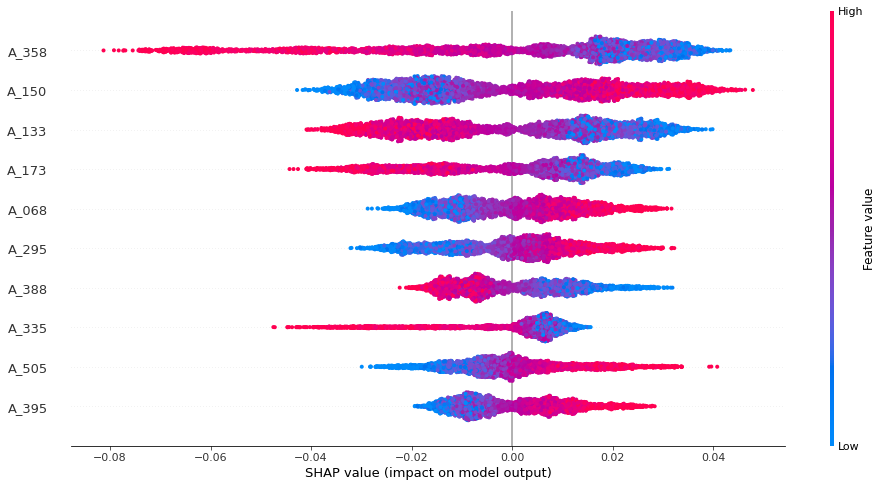

In [139]:
shap.summary_plot(rf_shap_values[0], X_rf, max_display=10, plot_type='dot', plot_size=(16, 8))

In [166]:
rf_shap_sum = np.abs(rf_shap_values[0]).mean(axis=0)
rf_importance_df = pd.DataFrame([X_rf.columns.tolist(), rf_shap_sum.tolist()]).T
rf_importance_df.columns = ['column_name', 'shap_importance']
rf_importance_df = rf_importance_df.sort_values('shap_importance', ascending=False)
rf_importance_df

,column_name,shap_importance
0,A_358,0.0248559
3,A_150,0.0189287
1,A_133,0.0180962
6,A_173,0.0149259
104,A_068,0.0105715
...,...,...
75,A_366,0.000681426
72,A_196,0.00067045
114,A_310,0.000650914
18,A_251,0.000642825


Теперь обучим случайный лес на всех признаках, настроив гиперпараметры.

In [112]:
def rf_full_objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 800)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_depth = trial.suggest_int('max_depth', 2, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 1, 100)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 50)
    
    rf_clf = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion,
                                    max_depth=max_depth, min_samples_split=min_samples_split,
                                    min_samples_leaf=min_samples_leaf, n_jobs=3)
    score = cross_val_score(rf_clf, X_full, y, n_jobs=3, scoring='roc_auc').mean()
    return score


In [113]:
rf_full_study = optuna.create_study(direction='maximize')
rf_full_study.optimize(rf_full_objective, n_trials=30)
rf_full_study.best_trial

[I 2021-05-13 06:41:10,663] A new study created in memory with name: no-name-e43857eb-0f51-47a1-b0d9-28d26bea7b5a
[I 2021-05-13 06:43:21,013] Trial 0 finished with value: 0.7757871066512976 and parameters: {'n_estimators': 793, 'criterion': 'entropy', 'max_depth': 30, 'min_samples_split': 18, 'min_samples_leaf': 12}. Best is trial 0 with value: 0.7757871066512976.
[I 2021-05-13 06:44:06,625] Trial 1 finished with value: 0.753768362842787 and parameters: {'n_estimators': 446, 'criterion': 'entropy', 'max_depth': 28, 'min_samples_split': 15, 'min_samples_leaf': 37}. Best is trial 0 with value: 0.7757871066512976.
[I 2021-05-13 06:44:48,465] Trial 2 finished with value: 0.7624400782539293 and parameters: {'n_estimators': 762, 'criterion': 'gini', 'max_depth': 42, 'min_samples_split': 87, 'min_samples_leaf': 43}. Best is trial 0 with value: 0.7757871066512976.
[I 2021-05-13 06:44:58,324] Trial 3 finished with value: 0.7337113693388877 and parameters: {'n_estimators': 92, 'criterion': 'entr

FrozenTrial(number=0, values=[0.7757871066512976], datetime_start=datetime.datetime(2021, 5, 13, 6, 41, 10, 664713), datetime_complete=datetime.datetime(2021, 5, 13, 6, 43, 21, 12251), params={'n_estimators': 793, 'criterion': 'entropy', 'max_depth': 30, 'min_samples_split': 18, 'min_samples_leaf': 12}, distributions={'n_estimators': IntUniformDistribution(high=800, low=10, step=1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy')), 'max_depth': IntUniformDistribution(high=100, low=2, step=1), 'min_samples_split': IntUniformDistribution(high=100, low=1, step=1), 'min_samples_leaf': IntUniformDistribution(high=50, low=1, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=0, state=TrialState.COMPLETE, value=None)

In [150]:
rf_full = RandomForestClassifier(n_jobs=3, **rf_full_study.best_params)
rf_full.fit(X_full, y)

RandomForestClassifier(criterion='entropy', max_depth=30, min_samples_leaf=12,
                       min_samples_split=18, n_estimators=793, n_jobs=3)

In [151]:
rf_full_explainer = shap.Explainer(rf_full)
rf_full_shap_values = rf_full_explainer.shap_values(X_full)

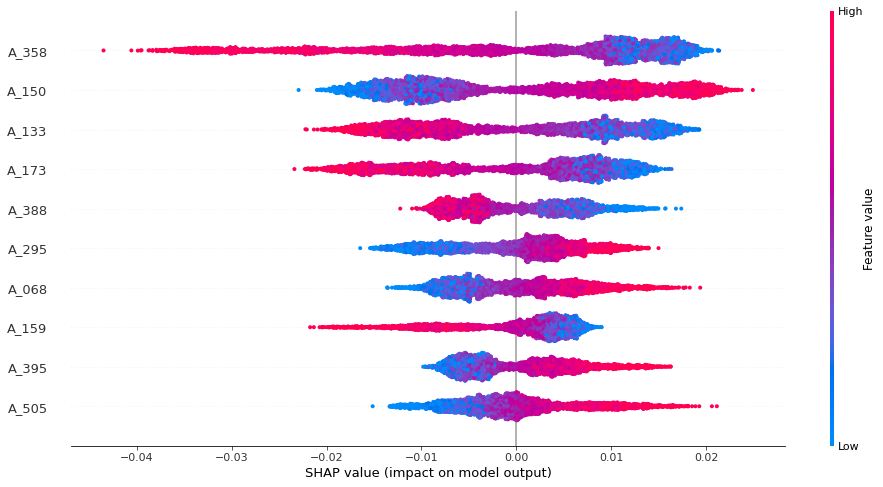

In [152]:
shap.summary_plot(rf_full_shap_values[0], X_full, max_display=10, plot_type='dot', plot_size=(16, 8))

In [167]:
rf_full_shap_sum = np.abs(rf_full_shap_values[0]).mean(axis=0)
rf_full_importance_df = pd.DataFrame([X_full.columns.tolist(), rf_full_shap_sum.tolist()]).T
rf_full_importance_df.columns = ['column_name', 'shap_importance']
rf_full_importance_df = rf_full_importance_df.sort_values('shap_importance', ascending=False)
rf_full_importance_df

,column_name,shap_importance
358,A_358,0.0134774
150,A_150,0.0110211
133,A_133,0.00990109
173,A_173,0.0089882
388,A_388,0.00546077
...,...,...
460,A_460,0.000186247
120,A_120,0.000185481
246,A_246,0.000184741
496,A_496,0.000178086


Для сравнения множества признаков с множеством из предыдущего задания отберем так же 150 наиболее важных, согласно shap_values

In [171]:
shap_150f = rf_full_importance_df['column_name'][:150].values
X_rf_shap_150f = X_full[shap_150f]
X_rf_shap_150f

,A_358,A_150,A_133,A_173,A_388,A_295,A_068,A_159,A_395,A_505,...,A_056,A_417,A_399,A_168,A_398,A_372,A_206,A_304,A_267,A_227
0,0.591261,0.744134,0.496058,0.640585,0.449215,0.547391,0.654991,0.810844,0.547420,0.435012,...,0.745386,0.660571,0.733987,0.889239,0.642675,0.406965,0.366992,0.609063,0.395418,0.573808
1,0.519088,0.574902,0.582850,0.700559,0.794306,0.478361,0.595276,0.562802,0.729999,0.556442,...,0.485291,0.711827,0.643460,0.800513,0.691561,0.546789,0.296814,0.712919,0.520261,0.593439
2,0.588222,0.438781,0.783633,0.530311,0.552203,0.476223,0.596451,0.394079,0.453997,0.641601,...,0.592846,0.632571,0.645016,0.493342,0.596698,0.676262,0.544344,0.729216,0.565727,0.365689
3,0.546976,0.704922,0.337422,0.617346,0.626508,0.698364,0.648654,0.621937,0.552406,0.683112,...,0.616044,0.441342,0.575513,0.343417,0.591991,0.709392,0.561573,0.477420,0.398454,0.579881
4,0.453254,0.631068,0.641685,0.530538,0.650282,0.630812,0.592623,0.469864,0.653509,0.725146,...,0.432282,0.466212,0.275044,0.552641,0.560996,0.407625,0.600089,0.309326,0.683037,0.562503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4156,0.346998,0.682406,0.757333,0.543014,0.541818,0.651720,0.731584,0.654163,0.695487,0.743528,...,0.882210,0.921689,0.425771,0.460239,0.667662,0.649535,0.671070,0.707451,0.441914,0.604443
4157,0.565258,0.645101,0.519942,0.736025,0.742848,0.645852,0.723924,0.493368,0.455476,0.529520,...,0.510615,0.531807,0.621289,0.232246,0.712102,0.723046,0.515198,0.498570,0.440671,0.806225
4158,0.348371,0.541598,0.589804,0.696409,0.415180,0.571605,0.629417,0.871393,0.585099,0.616331,...,0.771409,0.562588,0.546724,0.540201,0.893150,0.490580,0.625685,0.689613,0.717632,0.604387
4159,0.500692,0.577835,0.605979,0.614561,0.460771,0.639211,0.424401,0.684064,0.516506,0.451451,...,0.766846,0.427083,0.511662,0.651804,0.604675,0.513684,0.568388,0.658127,0.564197,0.451313


In [173]:
rf_shap_150f_score = cross_val_score(rf_full, X_rf_shap_150f, y, scoring='roc_auc', n_jobs=3).mean()
rf_shap_150f_score

0.7856590168288303

Видим, что даже без подбора гиперпараметров качество улучшилось! Попробуем теперь их подобрать.

In [174]:
def rf_shap_150f_objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 800)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_depth = trial.suggest_int('max_depth', 2, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 1, 100)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 50)
    
    rf_clf = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion,
                                    max_depth=max_depth, min_samples_split=min_samples_split,
                                    min_samples_leaf=min_samples_leaf, n_jobs=3)
    score = cross_val_score(rf_clf, X_rf_shap_150f, y, n_jobs=3, scoring='roc_auc').mean()
    return score


In [175]:
rf_shap_150f_study = optuna.create_study(direction='maximize')
rf_shap_150f_study.optimize(rf_shap_150f_objective, n_trials=30)
rf_shap_150f_study.best_trial

[I 2021-05-15 12:16:51,340] A new study created in memory with name: no-name-a9169ba5-bae0-4a03-9700-b56c9dd97dad
[I 2021-05-15 12:17:42,975] Trial 0 finished with value: 0.7707351651094289 and parameters: {'n_estimators': 780, 'criterion': 'entropy', 'max_depth': 17, 'min_samples_split': 87, 'min_samples_leaf': 32}. Best is trial 0 with value: 0.7707351651094289.
[I 2021-05-15 12:17:51,410] Trial 1 finished with value: 0.7694092781332965 and parameters: {'n_estimators': 199, 'criterion': 'gini', 'max_depth': 22, 'min_samples_split': 72, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.7707351651094289.
[I 2021-05-15 12:18:09,061] Trial 2 finished with value: 0.774740755951149 and parameters: {'n_estimators': 489, 'criterion': 'gini', 'max_depth': 25, 'min_samples_split': 68, 'min_samples_leaf': 25}. Best is trial 2 with value: 0.774740755951149.
[I 2021-05-15 12:18:38,441] Trial 3 finished with value: 0.776546741226378 and parameters: {'n_estimators': 400, 'criterion': 'entropy',

FrozenTrial(number=22, values=[0.7906031265162177], datetime_start=datetime.datetime(2021, 5, 15, 12, 31, 1, 690075), datetime_complete=datetime.datetime(2021, 5, 15, 12, 32, 18, 122729), params={'n_estimators': 698, 'criterion': 'entropy', 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 2}, distributions={'n_estimators': IntUniformDistribution(high=800, low=10, step=1), 'criterion': CategoricalDistribution(choices=('gini', 'entropy')), 'max_depth': IntUniformDistribution(high=50, low=2, step=1), 'min_samples_split': IntUniformDistribution(high=100, low=1, step=1), 'min_samples_leaf': IntUniformDistribution(high=50, low=1, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=22, state=TrialState.COMPLETE, value=None)

Даже взяв количество признаков "наугад", получаем существенное улучшение качества, что свидетельствует о хорошей работе shap'а (явно выигрышной, относительно способа ранжирования из предыдущего задания)

Теперь сравним множества отобранных shap'ом признаков с множеством из предыдущего задания.

In [190]:
rf_afs_features = X_rf.columns
rf_shap_features = X_rf_shap_150f.columns
pd.Series(np.in1d(rf_afs_features, rf_shap_features)).value_counts()

False    82
True     68
dtype: int64

Видим, что множества не совпадают даже на половину, что свидетельствует о различном подходе к ранжированию признаков 

**Задание 7** (0.5 балл)
    Сравните модели из заданий 3,4,5

* *KNN*.
Показал себя лучше всех с точки зрения качества и достаточно хорошо с точки зрения скорости обучения и подбора признаков. Feature Selector отобрал для него много признаков, засчет чего модель стала довольно устойчивой к отклонениям в каждом из них (что видно по перестановочному тесту). Параметром, дающим ключевой прирост, как и ожидалось, оказалось количество соседей.
* *Decision Tree*.
По результатам вполне очевидно, что дерево решений сильно проигрывает остальным моделям. Немного улучшает ситуацию предварительное ограничение глубины дерева (во избежание переобучения): это подняло скор на 0.045, а также позволило взять меньше признаков, из-за чего они стали достаточно важны для модели. Однако даже с учетом этого, дерево находится далеко от других алгоритмов в терминах качества. Единственным преимуществом данной модели оказалась относительно высокая скорость работы с ней на всех этапах.
* *Random Forest*.
Случайный лес оказался неплох в качестве, однако его низкая скорость обучения доставила некторые сложности при отборе признаков и настройке гиперпараметров. Идея ограничения глубины деревьев здесь тоже приносит плоды (+0.015 к скору). Ключевым параметром ожидаемо оказался размер леса.

**Задание 8** (2 балл)
    Постройте линейный ансамбль из лучших моделей.

Поскольку лучший результат давали модели логистической регрессии c L2-регуляризацией, случайного леса и KNN, построим их смесь. Начнем с обучения KNN по признакам, отобранным для случайного леса в предыдущем задании.

In [495]:
def knn_full_objective(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 500)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    p = trial.suggest_categorical('p', [1, 2])
    leaf_size = trial.suggest_int('leaf_size', 1, 100)
    
    knn_clf = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, p=p,
                                   leaf_size=leaf_size, n_jobs=3)
    score = cross_val_score(knn_clf, X_full[rf_shap_features], y, n_jobs=3, scoring='roc_auc').mean()
    return score


In [496]:
knn_full_study = optuna.create_study(direction='maximize')
knn_full_study.optimize(knn_full_objective, n_trials=30)
knn_full_study.best_trial

[I 2021-05-15 17:42:06,365] A new study created in memory with name: no-name-77eb610c-e266-41d5-a57f-a5b1d3a447b4
[I 2021-05-15 17:42:08,545] Trial 0 finished with value: 0.7843698040827692 and parameters: {'n_neighbors': 113, 'weights': 'distance', 'p': 1, 'leaf_size': 46}. Best is trial 0 with value: 0.7843698040827692.
[I 2021-05-15 17:42:09,210] Trial 1 finished with value: 0.7979254616174993 and parameters: {'n_neighbors': 439, 'weights': 'distance', 'p': 2, 'leaf_size': 19}. Best is trial 1 with value: 0.7979254616174993.
[I 2021-05-15 17:42:09,884] Trial 2 finished with value: 0.7628052677771608 and parameters: {'n_neighbors': 50, 'weights': 'uniform', 'p': 2, 'leaf_size': 43}. Best is trial 1 with value: 0.7979254616174993.
[I 2021-05-15 17:42:10,986] Trial 3 finished with value: 0.774718881592523 and parameters: {'n_neighbors': 67, 'weights': 'distance', 'p': 1, 'leaf_size': 99}. Best is trial 1 with value: 0.7979254616174993.
[I 2021-05-15 17:42:11,532] Trial 4 finished with 

FrozenTrial(number=28, values=[0.801794929628052], datetime_start=datetime.datetime(2021, 5, 15, 17, 42, 36, 673718), datetime_complete=datetime.datetime(2021, 5, 15, 17, 42, 37, 911594), params={'n_neighbors': 467, 'weights': 'distance', 'p': 1, 'leaf_size': 65}, distributions={'n_neighbors': IntUniformDistribution(high=500, low=1, step=1), 'weights': CategoricalDistribution(choices=('uniform', 'distance')), 'p': CategoricalDistribution(choices=(1, 2)), 'leaf_size': IntUniformDistribution(high=100, low=1, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=28, state=TrialState.COMPLETE, value=None)

In [500]:
knn_full = KNeighborsClassifier(n_jobs=3, **knn_full_study.best_trial.params)

Реализуем обертку над произвольным классификатором, позволяющую обучать его на некотором признаковом наборе поданой выборки. Это будет удобно для блендинга классификаторов, работающих на разных наборах фичей.

In [501]:
class ClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, clf, columns):
        self.clf = clf
        self.columns = columns
        self.classes_ = [0, 1]
        
    def fit(self, X, y):
        self.clf.fit(X[self.columns], y)
        
    def predict(self, X):
        return self.clf.predict(X[self.columns])
    
    def predict_proba(self, X):
        return self.clf.predict_proba(X[self.columns])
    
    def decision_function(self, X):
        return self.clf.predict_proba(X[self.columns])[:, 1]


In [502]:
log_reg_210f = ClassifierWrapper(log_reg_l2, GetNBestLogRegFeatures(log_reg_l2, X_full, y, 210)[:, 1])
rf_shap_150f = ClassifierWrapper(RandomForestClassifier(n_jobs=3, **rf_shap_150f_study.best_trial.params,
                                                        random_state=228),
                                 columns=rf_shap_features)
knn_shap_150f = ClassifierWrapper(knn_full, columns=rf_shap_features)

In [503]:
estimators_ = [('log_reg', log_reg_210f), ('rf', rf_shap_150f), ('knn', knn_shap_150f)]
stacker = StackingClassifier(estimators=estimators_, final_estimator=LogisticRegression())

In [504]:
cross_val_score(stacker, X_full, y, scoring='roc_auc', n_jobs=3).mean()

0.8289306620665542

**Задание 9** (2 балл)
    Постройте ансамбль из лучших моделей при помощи какой-либо реализации GBDT, например -- lightgbm или catboost

In [516]:
gbdt_stacker = StackingClassifier(estimators=estimators_,
                                   final_estimator=CatBoostClassifier(iterations=1000, verbose=True))

In [520]:
cross_val_score(gbdt_stacker, X_full, y, scoring='roc_auc', n_jobs=3).mean()

0.8218610871933734

In [518]:
gbdt_stacker.fit(X_full, y)

Learning rate set to 0.018938
0:	learn: 0.6855980	total: 61.3ms	remaining: 1m 1s
1:	learn: 0.6786009	total: 69.5ms	remaining: 34.7s
2:	learn: 0.6716037	total: 77.1ms	remaining: 25.6s
3:	learn: 0.6654448	total: 82ms	remaining: 20.4s
4:	learn: 0.6590741	total: 85.7ms	remaining: 17.1s
5:	learn: 0.6529273	total: 88.5ms	remaining: 14.7s
6:	learn: 0.6473616	total: 91.4ms	remaining: 13s
7:	learn: 0.6420072	total: 94ms	remaining: 11.7s
8:	learn: 0.6365167	total: 96.4ms	remaining: 10.6s
9:	learn: 0.6312927	total: 98.6ms	remaining: 9.76s
10:	learn: 0.6263574	total: 101ms	remaining: 9.06s
11:	learn: 0.6215826	total: 103ms	remaining: 8.48s
12:	learn: 0.6171232	total: 105ms	remaining: 7.99s
13:	learn: 0.6125308	total: 107ms	remaining: 7.57s
14:	learn: 0.6083253	total: 110ms	remaining: 7.2s
15:	learn: 0.6041624	total: 112ms	remaining: 6.88s
16:	learn: 0.6004494	total: 114ms	remaining: 6.59s
17:	learn: 0.5967484	total: 116ms	remaining: 6.34s
18:	learn: 0.5932448	total: 118ms	remaining: 6.12s
19:	lear

215:	learn: 0.4896190	total: 584ms	remaining: 2.12s
216:	learn: 0.4895752	total: 587ms	remaining: 2.12s
217:	learn: 0.4894830	total: 589ms	remaining: 2.11s
218:	learn: 0.4893263	total: 591ms	remaining: 2.11s
219:	learn: 0.4891663	total: 594ms	remaining: 2.1s
220:	learn: 0.4890844	total: 596ms	remaining: 2.1s
221:	learn: 0.4890119	total: 599ms	remaining: 2.1s
222:	learn: 0.4889868	total: 602ms	remaining: 2.1s
223:	learn: 0.4888909	total: 604ms	remaining: 2.09s
224:	learn: 0.4888779	total: 606ms	remaining: 2.09s
225:	learn: 0.4887615	total: 609ms	remaining: 2.08s
226:	learn: 0.4886812	total: 611ms	remaining: 2.08s
227:	learn: 0.4885755	total: 613ms	remaining: 2.08s
228:	learn: 0.4885045	total: 616ms	remaining: 2.07s
229:	learn: 0.4884658	total: 618ms	remaining: 2.07s
230:	learn: 0.4884073	total: 621ms	remaining: 2.07s
231:	learn: 0.4883570	total: 624ms	remaining: 2.07s
232:	learn: 0.4881985	total: 627ms	remaining: 2.06s
233:	learn: 0.4880994	total: 629ms	remaining: 2.06s
234:	learn: 0.48

380:	learn: 0.4772340	total: 972ms	remaining: 1.58s
381:	learn: 0.4771901	total: 974ms	remaining: 1.58s
382:	learn: 0.4771634	total: 977ms	remaining: 1.57s
383:	learn: 0.4770800	total: 979ms	remaining: 1.57s
384:	learn: 0.4770495	total: 981ms	remaining: 1.57s
385:	learn: 0.4769638	total: 984ms	remaining: 1.56s
386:	learn: 0.4768913	total: 986ms	remaining: 1.56s
387:	learn: 0.4768080	total: 988ms	remaining: 1.56s
388:	learn: 0.4767343	total: 991ms	remaining: 1.56s
389:	learn: 0.4766234	total: 994ms	remaining: 1.55s
390:	learn: 0.4765573	total: 996ms	remaining: 1.55s
391:	learn: 0.4764962	total: 1000ms	remaining: 1.55s
392:	learn: 0.4764363	total: 1s	remaining: 1.55s
393:	learn: 0.4763536	total: 1s	remaining: 1.54s
394:	learn: 0.4762941	total: 1.01s	remaining: 1.54s
395:	learn: 0.4761976	total: 1.01s	remaining: 1.54s
396:	learn: 0.4761701	total: 1.01s	remaining: 1.54s
397:	learn: 0.4760886	total: 1.01s	remaining: 1.53s
398:	learn: 0.4760069	total: 1.02s	remaining: 1.53s
399:	learn: 0.475

545:	learn: 0.4627158	total: 1.36s	remaining: 1.13s
546:	learn: 0.4626867	total: 1.36s	remaining: 1.13s
547:	learn: 0.4626099	total: 1.36s	remaining: 1.13s
548:	learn: 0.4624530	total: 1.37s	remaining: 1.12s
549:	learn: 0.4623250	total: 1.37s	remaining: 1.12s
550:	learn: 0.4621416	total: 1.37s	remaining: 1.12s
551:	learn: 0.4619614	total: 1.38s	remaining: 1.12s
552:	learn: 0.4618759	total: 1.38s	remaining: 1.11s
553:	learn: 0.4618283	total: 1.38s	remaining: 1.11s
554:	learn: 0.4617529	total: 1.38s	remaining: 1.11s
555:	learn: 0.4616800	total: 1.39s	remaining: 1.11s
556:	learn: 0.4615487	total: 1.39s	remaining: 1.1s
557:	learn: 0.4614886	total: 1.39s	remaining: 1.1s
558:	learn: 0.4613470	total: 1.39s	remaining: 1.1s
559:	learn: 0.4613079	total: 1.4s	remaining: 1.1s
560:	learn: 0.4611866	total: 1.4s	remaining: 1.09s
561:	learn: 0.4610682	total: 1.4s	remaining: 1.09s
562:	learn: 0.4609753	total: 1.4s	remaining: 1.09s
563:	learn: 0.4609000	total: 1.41s	remaining: 1.09s
564:	learn: 0.460841

714:	learn: 0.4477624	total: 1.75s	remaining: 698ms
715:	learn: 0.4477210	total: 1.75s	remaining: 695ms
716:	learn: 0.4475826	total: 1.75s	remaining: 693ms
717:	learn: 0.4474940	total: 1.76s	remaining: 690ms
718:	learn: 0.4473195	total: 1.76s	remaining: 688ms
719:	learn: 0.4473033	total: 1.76s	remaining: 686ms
720:	learn: 0.4472742	total: 1.77s	remaining: 684ms
721:	learn: 0.4472538	total: 1.77s	remaining: 681ms
722:	learn: 0.4472068	total: 1.77s	remaining: 679ms
723:	learn: 0.4471379	total: 1.77s	remaining: 677ms
724:	learn: 0.4470895	total: 1.78s	remaining: 674ms
725:	learn: 0.4469639	total: 1.78s	remaining: 672ms
726:	learn: 0.4468555	total: 1.78s	remaining: 670ms
727:	learn: 0.4468106	total: 1.78s	remaining: 667ms
728:	learn: 0.4467552	total: 1.79s	remaining: 665ms
729:	learn: 0.4466382	total: 1.79s	remaining: 662ms
730:	learn: 0.4465600	total: 1.79s	remaining: 660ms
731:	learn: 0.4464997	total: 1.79s	remaining: 657ms
732:	learn: 0.4464511	total: 1.8s	remaining: 655ms
733:	learn: 0

876:	learn: 0.4344417	total: 2.14s	remaining: 300ms
877:	learn: 0.4343764	total: 2.14s	remaining: 298ms
878:	learn: 0.4342577	total: 2.14s	remaining: 295ms
879:	learn: 0.4341657	total: 2.15s	remaining: 293ms
880:	learn: 0.4340728	total: 2.15s	remaining: 290ms
881:	learn: 0.4339909	total: 2.15s	remaining: 288ms
882:	learn: 0.4339411	total: 2.15s	remaining: 285ms
883:	learn: 0.4338304	total: 2.16s	remaining: 283ms
884:	learn: 0.4337589	total: 2.16s	remaining: 281ms
885:	learn: 0.4336994	total: 2.16s	remaining: 278ms
886:	learn: 0.4336659	total: 2.16s	remaining: 276ms
887:	learn: 0.4336507	total: 2.17s	remaining: 273ms
888:	learn: 0.4335615	total: 2.17s	remaining: 271ms
889:	learn: 0.4335415	total: 2.17s	remaining: 268ms
890:	learn: 0.4334139	total: 2.17s	remaining: 266ms
891:	learn: 0.4333841	total: 2.18s	remaining: 264ms
892:	learn: 0.4332605	total: 2.18s	remaining: 261ms
893:	learn: 0.4331844	total: 2.18s	remaining: 259ms
894:	learn: 0.4331372	total: 2.19s	remaining: 256ms
895:	learn: 

StackingClassifier(estimators=[('log_reg',
                                ClassifierWrapper(clf=LogisticRegression(max_iter=500,
                                                                         solver='liblinear'),
                                                  columns=array(['A_173', 'A_150', 'A_068', 'A_358', 'A_394', 'A_133', 'A_316',
       'A_203', 'A_351', 'A_295', 'A_137', 'A_344', 'A_159', 'A_008',
       'A_355', 'A_248', 'A_335', 'A_233', 'A_071', 'A_413', 'A_395',
       'A_377', 'A_385', 'A_090', 'A_487', 'A_031', 'A_392', 'A_...
                                ClassifierWrapper(clf=KNeighborsClassifier(leaf_size=65,
                                                                           n_jobs=3,
                                                                           n_neighbors=467,
                                                                           p=1,
                                                                           weights='distance')

**Задание 10** (0.5 балл)
    Сделайте вывод, помогло ли ансамблирование победить лучшие модели. В чем могут быть причины?

Ансамблирование действительно помогло победить лучшие модели. Это обяъясняется тем, что все взятые модели имеют разную природу, и ансамблирование позволяет консолидировать их сильные стороны и объеденить в одно предсказание.